# TCN for 1 droplet

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from callback import tcn
from callback import earlystopping

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data

In [3]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=3, axis=1)
    return df

df = mk_dataframe("230724/pos-1.dat")
df_ = df.values

In [13]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

df_scaled = scaler.fit_transform(df_)

In [14]:
# 1秒に1点
df_scaled = df_scaled[:36000:10]
df_scaled.shape

(3600, 2)

In [18]:
time_step = 200

len_seq = len(df_scaled)
data_size = len_seq - time_step + 1

data = np.zeros((data_size, 2, time_step))
t = np.zeros((data_size, 2))

In [19]:
for i in range(len(df_scaled) - time_step):
    data[i,0] = df_scaled[i:i+time_step, 0]
    data[i,1] = df_scaled[i:i+time_step, 1]
    t[i] = df_scaled[i+time_step]

In [20]:
data.shape

(3401, 2, 200)

In [21]:
t.shape

(3401, 2)

In [22]:
# 使用するテンソル
x = torch.Tensor(np.array(data).reshape(-1, 2, time_step)).to(device)
t = torch.Tensor(np.array(t).reshape(-1, 2)).to(device)

In [23]:
x.shape

torch.Size([3401, 2, 200])

In [61]:
X_train.size(0)

2720

## Train and Evaluate

In [62]:
def train(model, optimizer, lr, epoch, clip=-1):
    model.train()
    batch_idx = 1 # バッチが何回カウントされたか
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x, debug=False)
        loss = F.mse_loss(output, y)
        loss.backward()
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 100 == 0:
            cur_loss = total_loss / 100
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0
            
    return total_loss / batch_idx
            
def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [63]:
n_seq = x.size(0)

train_size = int(n_seq * 0.8)
test_size = n_seq - train_size
print("train size:{}, test size: {}".format(train_size, test_size))
X_train, Y_train = x[:train_size], t[:train_size]
X_test, Y_test = x[train_size:], t[train_size:]

train size:2720, test size: 681


In [67]:
batch_size = 100
epochs = 4
lr = 1e-3

model = tcn.myTCN(input_size=2, output_size=2, num_channels=[20]*7, kernel_size=7, dropout=0.0)
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

loss = {
    "train_loss":[], 
    "val_loss":[]
}
es = earlystopping.EarlyStopping(patience=10, verbose=1)

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, lr=lr, epoch=epoch, clip=-1)
    tloss = evaluate()
    
    loss["train_loss"].append(train_loss)
    loss["val_loss"].append(tloss)
    if es(tloss):
        break


Test set: Average loss: 0.061033


Test set: Average loss: 0.442903


Test set: Average loss: 0.062087


Test set: Average loss: 0.136922



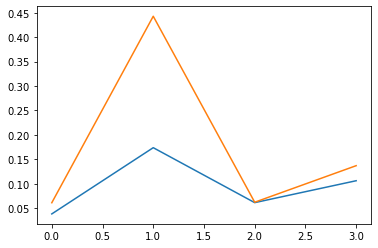

In [68]:
plt.plot(loss["train_loss"])
plt.plot(loss["val_loss"])

In [59]:
gen_time = 1000

gen = [[None, None] for i in range(time_step)]
z = X_test[0].reshape(1,2,-1)

for i in range(gen_time):
    model.eval()
    pred = model(z).data.cpu().numpy()
    z = np.concatenate([z.numpy().reshape(2,-1), pred.reshape(2,-1)], 1)
    z = z[:,1:]
    # print(z.shape)
    z = torch.Tensor(z.reshape(1,2,-1))
    gen.append([pred[0,0], pred[0,1]])

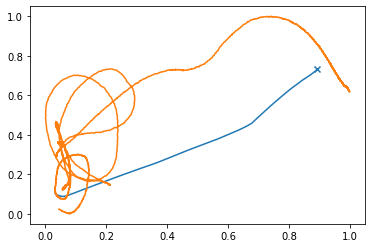

In [60]:
gen = np.array(gen)
plt.plot(gen[:,0], gen[:,1])


plt.scatter(gen[time_step,0], gen[time_step, 1], marker="x")
plt.plot(df_scaled[:,0], df_scaled[:,1])

In [31]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
myTCN                                    --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       320
│    └─Chomp1d: 2-2                      --
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Conv1d: 2-5                       2,840
│    └─Chomp1d: 2-6                      --
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Conv1d: 2-9                       60
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      2,840
│    └─Chomp1d: 2-12                     --
│    └─ReLU: 2-13                        --
│    └─Dropout: 2-14                     --
│    └─Conv1d: 2-15                      2,840
│    └─Chomp1d: 2-16                     --
│    └─ReLU: 2-17                        --
│    └─Dropout: 2-18                     --
│    └─ReLU: 2-19                        --
│    └─Conv1d: 2-